# ***Analisis Sentimen Komentar YouTube terhadap Kasus Dugaan Korupsi Migas Menggunakan Algoritma Support Vector Machine (SVM)***

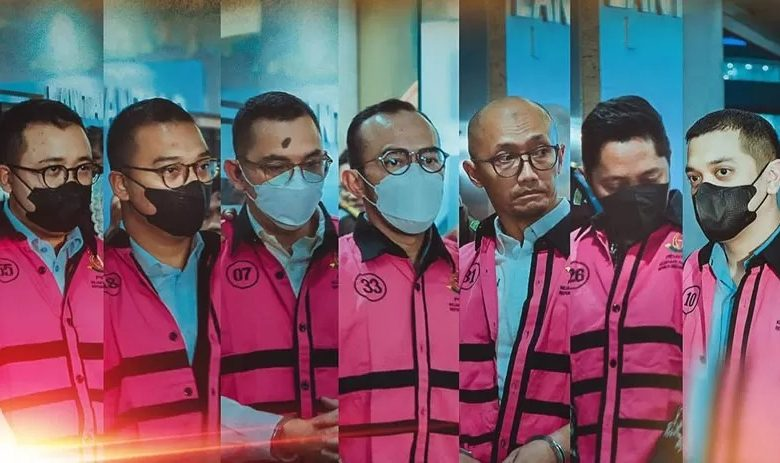

---
# ***CRAWLING DATA***

In [ ]:
from googleapiclient.discovery import build
import csv
import pandas as pd

# Masukkan API Key yang didapat dari Google Cloud Console
api_key = '##################################'
youtube = build('youtube', 'v3', developerKey=api_key)

# Fungsi untuk mengambil komentar dari video
def get_video_comments(video_id, max_comments):
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=2000,
            textFormat='plainText',
            pageToken=next_page_token
        ).execute()

        for item in response['items']:
            if len(comments) >= max_comments:
                break
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
            published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']

            comments.append({
                'author': author,
                'comment': comment,
                'likes': like_count,
                'published_at': published_at
            })

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments[:max_comments]

# Fungsi untuk menyimpan komentar ke file CSV
def save_comments_to_csv(comments, filename):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['author', 'comment', 'likes', 'published_at'])
        writer.writeheader()
        writer.writerows(comments)

# Fungsi utama untuk mengambil komentar dari beberapa video
def scrape_comments_from_videos(video_ids, total_comments, output_filename):
    all_comments = []
    comments_per_video = total_comments // len(video_ids)

    for video_id in video_ids:
        comments = get_video_comments(video_id, comments_per_video)
        all_comments.extend(comments)

    # Jika masih kurang, tambahkan sisanya dari video pertama
    if len(all_comments) < total_comments:
        extra_comments = total_comments - len(all_comments)
        extra_comments_from_first = get_video_comments(video_ids[0], extra_comments)
        all_comments.extend(extra_comments_from_first[:extra_comments])

    # Simpan hasilnya ke file CSV
    save_comments_to_csv(all_comments, output_filename)
    return all_comments

In [ ]:
# ID video YouTube yang ingin diambil
video_ids = ['wj_IGViGMAU','L-0-a3s5uhQ','eK3PPipfEoc',
             'vQvF6-LsW20','S3wBzFmM5RA','UVx3PBuvJZU','BGFH0qET5eU',
             'UuXO_l0jCwY','9yipI-ebl7g','d0lqMadS49k','fUgwRlY3Qy4']
total_comments = 30000
output_filename = 'datamigas.csv'

# Ambil komentar dan simpan ke file CSV
comments = scrape_comments_from_videos(video_ids, total_comments, output_filename)

df = pd.DataFrame(comments)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6871 entries, 0 to 6870
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        6871 non-null   object
 1   comment       6871 non-null   object
 2   likes         6871 non-null   int64 
 3   published_at  6871 non-null   object
dtypes: int64(1), object(3)
memory usage: 214.8+ KB


author                                            comment  likes  \
0      @JELLYSISCHA  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...      1   
1  @SardiniDini-r1s  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...      0   
2      @JELLYSISCHA  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...      1   
3   @abuabdullah403  Seharusnya di hukum mati dan di miskinkan kelu...      0   
4      @titotito403  Riza Cholid wajib ditangkap kejar dimana dia b...      0   

           published_at  
0  2025-10-25T05:57:50Z  
1  2025-10-25T05:57:08Z  
2  2025-10-25T05:55:49Z  
3  2025-10-25T05:55:19Z  
4  2025-10-25T05:50:54Z

---
# ***PREPROCESSING DATA***

In [ ]:
import pandas as pd

data = pd.read_csv("datamigas.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6871 entries, 0 to 6870
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        6871 non-null   object
 1   comment       6871 non-null   object
 2   likes         6871 non-null   int64 
 3   published_at  6871 non-null   object
dtypes: int64(1), object(3)
memory usage: 214.8+ KB


In [ ]:
data.head(5)

author                                            comment  likes  \
0      @JELLYSISCHA  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...      1   
1  @SardiniDini-r1s  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...      0   
2      @JELLYSISCHA  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...      1   
3   @abuabdullah403  Seharusnya di hukum mati dan di miskinkan kelu...      0   
4      @titotito403  Riza Cholid wajib ditangkap kejar dimana dia b...      0   

           published_at  
0  2025-10-25T05:57:50Z  
1  2025-10-25T05:57:08Z  
2  2025-10-25T05:55:49Z  
3  2025-10-25T05:55:19Z  
4  2025-10-25T05:50:54Z

In [ ]:
df  = pd.DataFrame(data[['comment']])
df.head(5)

comment
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...
3  Seharusnya di hukum mati dan di miskinkan kelu...
4  Riza Cholid wajib ditangkap kejar dimana dia b...

**PROSES HAPUS DATA DUPLIKAT**

---



In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6871 entries, 0 to 6870
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  6871 non-null   object
dtypes: object(1)
memory usage: 53.8+ KB


comment
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...
3  Seharusnya di hukum mati dan di miskinkan kelu...
4  Riza Cholid wajib ditangkap kejar dimana dia b...

In [ ]:
data = df[df.duplicated(subset="comment", keep=False)]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 6870
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  979 non-null    object
dtypes: object(1)
memory usage: 15.3+ KB


comment
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...
3  Seharusnya di hukum mati dan di miskinkan kelu...
4  Riza Cholid wajib ditangkap kejar dimana dia b...

In [ ]:
df.drop_duplicates(subset ="comment", keep = 'first', inplace = True)

In [ ]:
df.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6363 entries, 0 to 6420
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  6363 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


comment
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...
3  Seharusnya di hukum mati dan di miskinkan kelu...
4  Riza Cholid wajib ditangkap kejar dimana dia b...

**PROSES CLEANING**

---



In [ ]:
import re
import string
import nltk

# Fungsi untuk menghapus URL
def remove_URL(tweet):
    if tweet is not None and isinstance(tweet, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus HTML
def remove_html(tweet):
    if tweet is not None and isinstance(tweet, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus emoji
def remove_emoji(tweet):
    if tweet is not None and isinstance(tweet, str):
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoji
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0001F004-\U0001F0CF"  # Additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus simbol
def remove_symbols(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    return tweet

# Fungsi untuk menghapus angka
def remove_numbers(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'\d', '', tweet)
    return tweet

# Fungsi hapus username
def remove_usernames(text):
    if text is not None and isinstance(text, str):
        return re.sub(r'@\w+', '', text)
    else:
        return text

df['cleaning'] = df['comment'].apply(lambda x: remove_URL(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_usernames(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_html(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_emoji(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_symbols(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_numbers(x))

df.head(5)

comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...  
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...  
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...  
3  Seharusnya di hukum mati dan di miskinkan kelu...  
4  Riza Cholid wajib ditangkap kejar dimana dia b...

**PROSES CASE FOLDING**

---



In [ ]:
def case_folding(text):
    if isinstance(text, str):
        lowercase_text = text.lower()
        return lowercase_text
    else:
        return text

df['case_folding'] = df['cleaning'].apply(case_folding)
df.head(5)

comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                        case_folding  
0  orang paling koruptor di nkri kok di biarin ma...  
1  klu orng nya belum di tsmgkap uang yg disita d...  
2  hallo hallo jaksa riza callid ada di malaysia ...  
3  seharusnya di hukum mati dan di miskinkan kelu...  
4  riza cholid wajib ditangkap kejar dimana dia b...

**Normalisasi Kata**

---



In [ ]:
import pandas as pd
import requests
from io import BytesIO

# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

# Baca dataset kamu (pastikan df sudah tersedia)
data = pd.DataFrame(df[['comment','cleaning','case_folding']])
data.head()

comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                        case_folding  
0  orang paling koruptor di nkri kok di biarin ma...  
1  klu orng nya belum di tsmgkap uang yg disita d...  
2  hallo hallo jaksa riza callid ada di malaysia ...  
3  seharusnya di hukum mati dan di miskinkan kelu...  
4  riza cholid wajib ditangkap kejar dimana dia b...

In [ ]:
# Unduh dan baca kamus dari GitHub
url = "https://github.com/analysisdatasentiment/kamus_kata_baku/raw/main/kamuskatabaku.xlsx"
response = requests.get(url)
file_excel = BytesIO(response.content)
kamus_data = pd.read_excel(file_excel)

# Buat dictionary dari kamus
kamus_tidak_baku_dict = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [ ]:
# Terapkan fungsi normalisasi
data[['normalisasi', 'Kata_Baku', 'Kata_Tidak_Baku', 'Kata_Tidak_Baku_Hash']] = data['case_folding'].apply(
    lambda x: pd.Series(replace_taboo_words(x, kamus_tidak_baku_dict))
)

# Ambil kolom yang relevan
df = pd.DataFrame(data[['comment','cleaning','case_folding','normalisasi']])
df.head(5)

comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                        case_folding  \
0  orang paling koruptor di nkri kok di biarin ma...   
1  klu orng nya belum di tsmgkap uang yg disita d...   
2  hallo hallo jaksa riza callid ada di malaysia ...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                         normalisasi  
0  orang paling koruptor di nkri kok di biarkan m...  
1  kalau orang ya belum di tsmgkap uang yang disi...  
2  halo halo jaksa riza callid ada di malaysia se...  
3  seharusnya di hukum mati dan di miskinkan kelu...  
4  riza cholid wajib ditangkap kejar dimana dia b...

**TOKENIZATION**

---



In [ ]:
def tokenize(text):
    tokens = text.split()
    return tokens

df['tokenize'] = df['normalisasi'].apply(tokenize)

df.head(5)

comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                        case_folding  \
0  orang paling koruptor di nkri kok di biarin ma...   
1  klu orng nya belum di tsmgkap uang yg disita d...   
2  hallo hallo jaksa riza callid ada di malaysia ...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                         normalisasi  \
0  orang paling koruptor di nkri kok di biarkan m...   
1  kalau orang ya belum di tsmgkap uang yang disi...   
2  halo halo jaksa riza callid ada di malaysia se...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                            tokenize  
0  [orang, paling, koruptor, di, nkri, kok, di, b...  
1  [kalau, orang, ya, belum, di, tsmgkap, uang, y...  
2  [halo, halo, jaksa, riza, callid, ada, di, mal...  
3  [seharusnya, di, hukum, mati, dan, di, miskink...  
4  [riza, cholid, wajib, ditangkap, kejar, dimana...

**PROSES STOPWORD REMOVAL**

---



In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Ubah hasil list jadi string
df['stopword removal'] = df['tokenize'].apply(
    lambda x: " ".join(remove_stopwords(x))
)

df.head(5)

comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                        case_folding  \
0  orang paling koruptor di nkri kok di biarin ma...   
1  klu orng nya belum di tsmgkap uang yg disita d...   
2  hallo hallo jaksa riza callid ada di malaysia ...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                         normalisasi  \
0  orang paling koruptor di nkri kok di biarkan m...   
1  kalau orang ya belum di tsmgkap uang yang disi...   
2  halo halo jaksa riza callid ada di malaysia se...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                            tokenize  \
0  [orang, paling, koruptor, di, nkri, kok, di, b...   
1  [kalau, orang, ya, belum, di, tsmgkap, uang, y...   
2  [halo, halo, jaksa, riza, callid, ada, di, mal...   
3  [seharusnya, di, hukum, mati, dan, di, miskink...   
4  [riza, cholid, wajib, ditangkap, kejar, dimana...   

                                    stopword removal  
0  orang koruptor nkri biarkan melenggang negara ...  
1  orang ya tsmgkap uang disita harta ya sita uan...  
2  halo halo jaksa riza callid malaysia riza oran...  
3                    hukum mati miskinkan kelurganya  
4  riza cholid wajib ditangkap kejar dimana inter...

In [ ]:
from collections import Counter

all_text = ' '.join(df['stopword removal'].astype(str))
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())

word_list = all_text.split()
word_freq = Counter(word_list)

sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
df_freq = pd.DataFrame(sorted_freq, columns=['Kata', 'Frekuensi'])

df_freq.to_csv('frekuensi_kata_awal.csv', index=False)
print("✅ File 'frekuensi_kata_awal.csv' berhasil disimpan.")
df_freq.info()
df_freq.head(50)

✅ File 'frekuensi_kata_awal.csv' berhasil disimpan.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13819 entries, 0 to 13818
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Kata       13819 non-null  object
 1   Frekuensi  13819 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 216.1+ KB


Kata  Frekuensi
0       rakyat       1020
1           ya        990
2        orang        924
3       negara        897
4    indonesia        819
5       jokowi        705
6      prabowo        688
7        mafia        656
8     presiden        628
9     koruptor        581
10       hukum        569
11     korupsi        522
12        riza        403
13        mati        371
14      negeri        291
15      mahfud        291
16      semoga        278
17       allah        268
18      chalid        267
19         sih        264
20     tangkap        255
21     pejabat        244
22      berani        223
23   pertamina        219
24        uang        217
25    sudirman        185
26      bangsa        184
27      minyak        179
28        said        174
29       pakai        171
30         tau        162
31       migas        161
32       takut        161
33        aset        157
34        kuat        155
35       kayak        153
36         bpk        152
37      bahlil        147
38    pemimpin        146
39        omon        146
40      partai        141
41  pemerintah        141
42        biar        138
43         dpr        136
44       jujur        135
45  masyarakat        132
46       sehat        125
47        maju        124
48     menteri        124
49       hidup        120

In [ ]:
hapus_kata = ['ya','sih','tau','biar']

# hapus kata dari teks
df['stopword removal'] = df['stopword removal'].apply(
    lambda x: ' '.join([kata for kata in x.split() if kata not in hapus_kata]))

df['stopword removal'].str.contains('|'.join(hapus_kata)).sum()

np.int64(3035)

In [ ]:
# ---  Membuat kamus kata tidak baku -> kata baku
kamus_tidak_baku = {
    'bpk':'bapan pemeriksa keuangan',
    'dpr':'dewan perwakilan rakyat'
}

def perbaiki_kata(teks):
    kata_list = teks.split()
    hasil = [kamus_tidak_baku.get(kata, kata) for kata in kata_list]
    return ' '.join(hasil)

df['stopword removal'] = df['stopword removal'].astype(str).apply(perbaiki_kata)


In [ ]:
from collections import Counter
import re

all_text = ' '.join(df['stopword removal'].astype(str))
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())

word_list = all_text.split()
word_freq = Counter(word_list)

sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
df_freq = pd.DataFrame(sorted_freq, columns=['Kata', 'Frekuensi'])

# df_freq.info()
df_freq.head(50)

Kata  Frekuensi
0       rakyat       1156
1        orang        924
2       negara        897
3    indonesia        819
4       jokowi        705
5      prabowo        688
6        mafia        656
7     presiden        628
8     koruptor        581
9        hukum        569
10     korupsi        522
11        riza        403
12        mati        371
13      negeri        291
14      mahfud        291
15      semoga        278
16       allah        268
17      chalid        267
18     tangkap        255
19     pejabat        244
20      berani        223
21   pertamina        219
22        uang        217
23    sudirman        185
24      bangsa        184
25      minyak        179
26    keuangan        176
27        said        174
28       pakai        171
29       migas        161
30       takut        161
31        aset        157
32        kuat        155
33       kayak        153
34       bapan        152
35   pemeriksa        152
36      bahlil        147
37    pemimpin        146
38        omon        146
39       dewan        145
40      partai        141
41  pemerintah        141
42  perwakilan        137
43       jujur        135
44  masyarakat        132
45       sehat        125
46        maju        124
47     menteri        124
48       hidup        120
49     purbaya        120

**WORDCLOUD SETELAH PREPROCESSING**

---



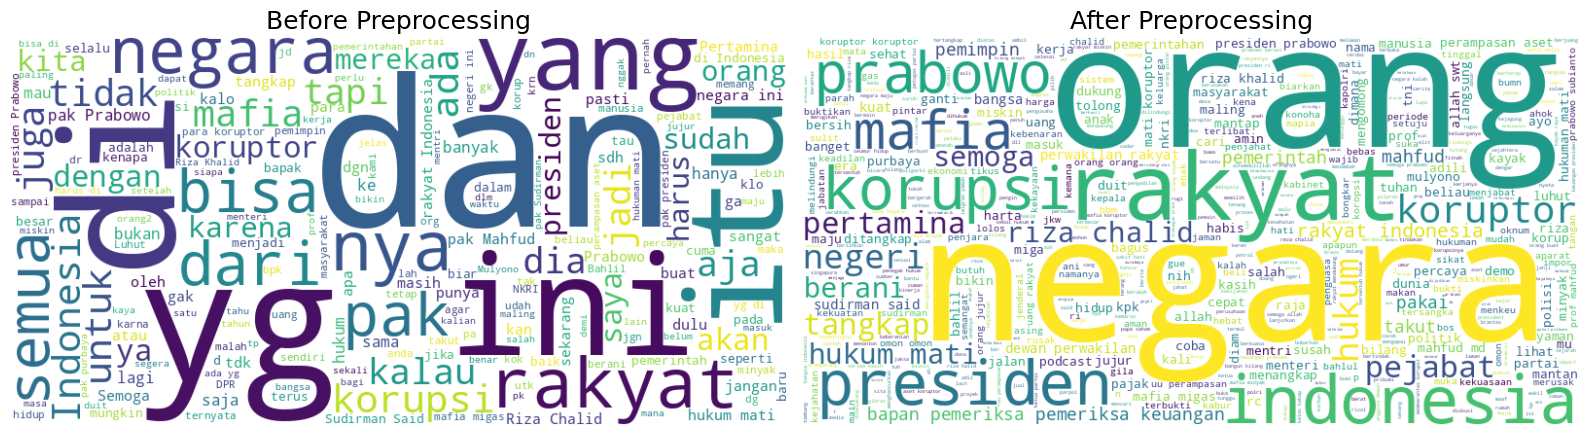

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Buat stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'lu','jokowi'])

# WordCloud Before
text_before = ' '.join(
    df['comment']
    .astype(str)
    .tolist()
)

wc_before = WordCloud(
    stopwords=stopwords,
    background_color="white",
    max_words=200,
    width=800,
    height=400
).generate(text_before)

# WordCloud After (dari kolom 'stopword removal')
text_after = ' '.join(
    [" ".join(eval(x) if isinstance(x, str) and x.startswith('[') else x.split())
     for x in df['stopword removal'].astype(str)]
)

wc_after = WordCloud(
    stopwords=stopwords,
    background_color="white",
    max_words=500,
    width=800,
    height=400
).generate(text_after)

# Visualisasi side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_before, interpolation='bilinear')
plt.axis("off")
plt.title("Before Preprocessing", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_after, interpolation='bilinear')
plt.axis("off")
plt.title("After Preprocessing", fontsize=18)

plt.tight_layout()
plt.show()

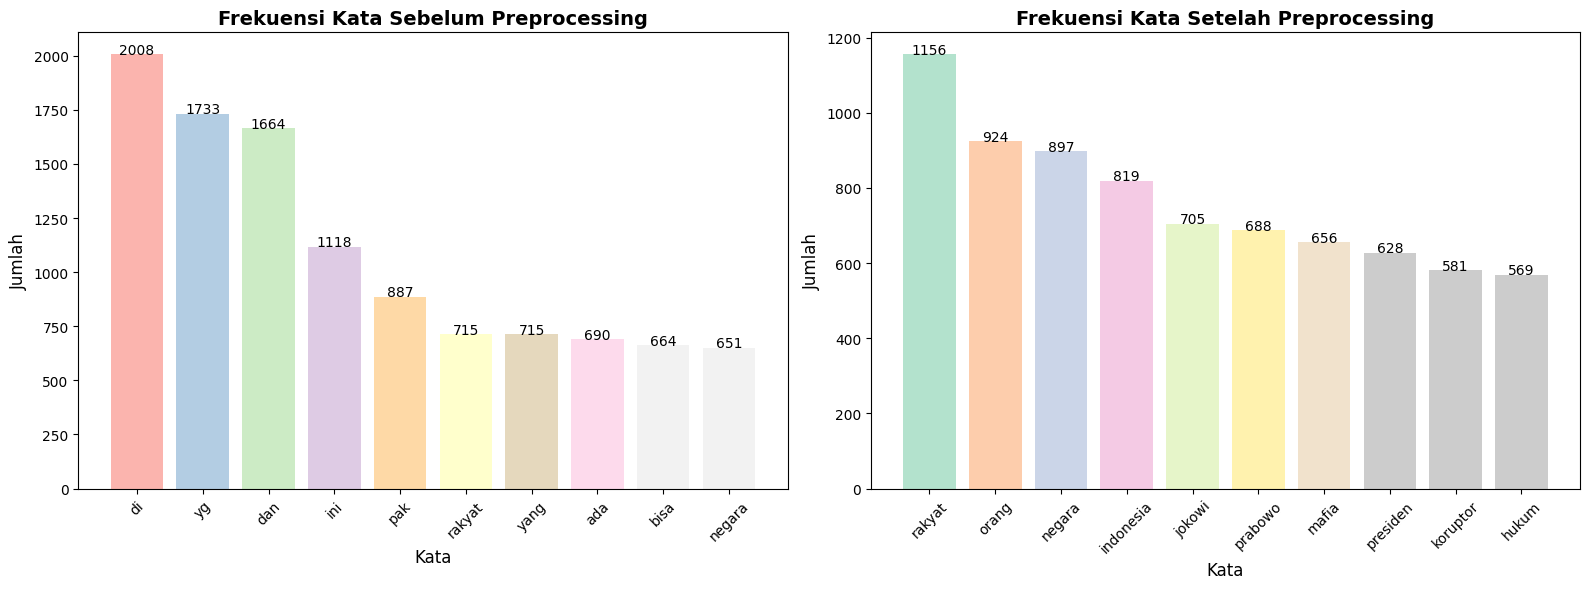

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS
import re

# Set stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'lu'])

# Fungsi helper untuk membersihkan tanda kutip, [ ], , dll
def clean_text_column(series):
    cleaned = []
    for text in series.astype(str):
        # Hapus [ ], tanda petik tunggal/ganda, koma
        text = re.sub(r"[\[\]\'\",]", "", text)
        cleaned.append(text.strip())
    return " ".join(cleaned)

# BEFORE
all_text_before = clean_text_column(df["comment"])
words_before = all_text_before.split()
filtered_words_before = [word for word in words_before if word.lower() not in stopwords]
word_counts_before = Counter(filtered_words_before)
top_words_before = word_counts_before.most_common(10)
word_before, count_before = zip(*top_words_before)

# AFTER
all_text_after = clean_text_column(df["stopword removal"])
words_after = all_text_after.split()
filtered_words_after = [word for word in words_after if word.lower() not in stopwords]
word_counts_after = Counter(filtered_words_after)
top_words_after = word_counts_after.most_common(10)
word_after, count_after = zip(*top_words_after)

# Plot berdampingan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BEFORE Plot
colors_before = plt.cm.Pastel1(range(len(word_before)))
bars1 = axes[0].bar(word_before, count_before, color=colors_before)
axes[0].set_title("Frekuensi Kata Sebelum Preprocessing", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Kata", fontsize=12)
axes[0].set_ylabel("Jumlah", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars1, count_before):
    axes[0].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

# AFTER Plot
colors_after = plt.cm.Pastel2(range(len(word_after)))
bars2 = axes[1].bar(word_after, count_after, color=colors_after)
axes[1].set_title("Frekuensi Kata Setelah Preprocessing", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Kata", fontsize=12)
axes[1].set_ylabel("Jumlah", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for bar, count in zip(bars2, count_after):
    axes[1].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('Hasil_Preprocessing_Data.csv',encoding='utf8', index=False);

# ***PELEBALAN DATA METODE LAXICON BASED 3 CLASS***

In [ ]:
import pandas as pd

data = pd.read_csv("Hasil_Preprocessing_Data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6363 entries, 0 to 6362
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   comment           6363 non-null   object
 1   cleaning          6328 non-null   object
 2   case_folding      6328 non-null   object
 3   normalisasi       6324 non-null   object
 4   tokenize          6363 non-null   object
 5   stopword removal  6308 non-null   object
dtypes: object(6)
memory usage: 298.4+ KB


comment  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum. Di. Tsmgkap. Uang yg disit...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                            cleaning  \
0  ORANG PALING KORUPTOR DI NKRI KOK DI BIARIN MA...   
1  Klu orng nya belum Di Tsmgkap Uang yg disita d...   
2  HALLO HALLO JAKSA RIZA CALLID ADA DI MALAYSIA ...   
3  Seharusnya di hukum mati dan di miskinkan kelu...   
4  Riza Cholid wajib ditangkap kejar dimana dia b...   

                                        case_folding  \
0  orang paling koruptor di nkri kok di biarin ma...   
1  klu orng nya belum di tsmgkap uang yg disita d...   
2  hallo hallo jaksa riza callid ada di malaysia ...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                         normalisasi  \
0  orang paling koruptor di nkri kok di biarkan m...   
1  kalau orang ya belum di tsmgkap uang yang disi...   
2  halo halo jaksa riza callid ada di malaysia se...   
3  seharusnya di hukum mati dan di miskinkan kelu...   
4  riza cholid wajib ditangkap kejar dimana dia b...   

                                            tokenize  \
0  ['orang', 'paling', 'koruptor', 'di', 'nkri', ...   
1  ['kalau', 'orang', 'ya', 'belum', 'di', 'tsmgk...   
2  ['halo', 'halo', 'jaksa', 'riza', 'callid', 'a...   
3  ['seharusnya', 'di', 'hukum', 'mati', 'dan', '...   
4  ['riza', 'cholid', 'wajib', 'ditangkap', 'keja...   

                                    stopword removal  
0  orang koruptor nkri biarkan melenggang negara ...  
1  orang tsmgkap uang disita harta sita uang bawa...  
2  halo halo jaksa riza callid malaysia riza oran...  
3                    hukum mati miskinkan kelurganya  
4  riza cholid wajib ditangkap kejar dimana inter...

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6308 entries, 0 to 6362
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   comment           6308 non-null   object
 1   cleaning          6308 non-null   object
 2   case_folding      6308 non-null   object
 3   normalisasi       6308 non-null   object
 4   tokenize          6308 non-null   object
 5   stopword removal  6308 non-null   object
dtypes: object(6)
memory usage: 345.0+ KB


In [ ]:
data = pd.DataFrame(data[['stopword removal']])
data.head(5)

stopword removal
0  orang koruptor nkri biarkan melenggang negara ...
1  orang tsmgkap uang disita harta sita uang bawa...
2  halo halo jaksa riza callid malaysia riza oran...
3                    hukum mati miskinkan kelurganya
4  riza cholid wajib ditangkap kejar dimana inter...

In [ ]:
import pandas as pd
import requests

# Unduh kamus leksikon positif dan negatif dari GitHub
positive_url = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
negative_url = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

positive_lexicon = set(pd.read_csv(positive_url, sep="\t", header=None)[0])
negative_lexicon = set(pd.read_csv(negative_url, sep="\t", header=None)[0])

# Fungsi untuk menentukan sentimen dan menghitung skornya
def determine_sentiment(text):
    if isinstance(text, str):
        positive_count = sum(1 for word in text.split() if word in positive_lexicon)
        negative_count = sum(1 for word in text.split() if word in negative_lexicon)
        sentiment_score = positive_count - negative_count
        if sentiment_score > 0:
            sentiment = "Positif"
        elif sentiment_score < 0:
            sentiment = "Negatif"
        else:
            sentiment = "Netral"
        return sentiment_score, sentiment
    return 0, "Netral"


# Tentukan sentimen dan skor untuk setiap ulasan
data[['Score', 'Sentiment']] = data['stopword removal'].apply(lambda x: pd.Series(determine_sentiment(x)))

# Tampilkan hasilnya
data.head(20)


stopword removal  Score Sentiment
0   orang koruptor nkri biarkan melenggang negara ...      0    Netral
1   orang tsmgkap uang disita harta sita uang bawa...     -1   Negatif
2   halo halo jaksa riza callid malaysia riza oran...      0    Netral
3                     hukum mati miskinkan kelurganya      0    Netral
4   riza cholid wajib ditangkap kejar dimana inter...     -2   Negatif
5   mengomong trussssss yuk yuk presiden prabowo g...      3   Positif
6   triliun yeah kerigian negara wow wow wow dorrr...      1   Positif
7   halo halo presiden prabowo gibran terhormat ko...      1   Positif
8                            tangkap rizakhalid adili     -1   Negatif
9   tembak mati ajatas tuduhan melarikan ketidakpa...     -3   Negatif
10                       apakabar ruu perampasan aset      0    Netral
11  uu perampasan aset tolong sahkan hukum mati ko...      0    Netral
12              negara kuat rakyat memdukung presiden      1   Positif
13  kadang percaya polisi menangkapnya tf mafia bi...      2   Positif
14  limimitit dpo buronan indonesia rakyat indones...     -2   Negatif
15                   riza halid lari uanguangnya bank     -1   Negatif
16  orang bikin juta rakyat menderita coba serahin...      0    Netral
17  selamat sukses prabowo memproses selslu mengob...      2   Positif
18  malu namamu bawa nama muhammad kelakuanmu beja...     -1   Negatif
19  riza chalid prabowo diadili bersekutu jokowi j...     -2   Negatif

/tmp/ipython-input-1910355637.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')


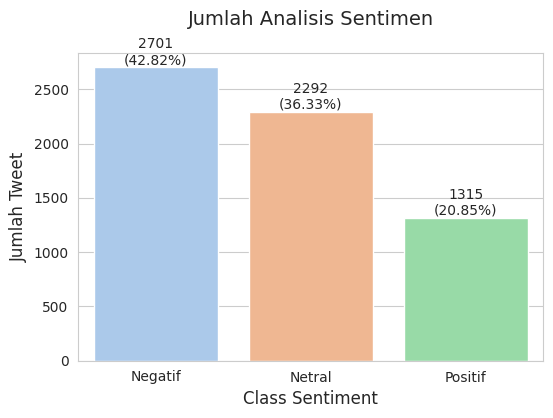

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_count = data['Sentiment'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Jumlah Analisis Sentimen', fontsize=14, pad=20)
plt.xlabel('Class Sentiment', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)

total = len(data['Sentiment'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [ ]:
data.to_csv('Hasil_Labelling_Data_3class.csv',encoding='utf8', index=False)

# ***WORDCLOUD***



In [ ]:
import pandas as pd

data = pd.read_csv("Hasil_Labelling_Data_3class.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


stopword removal  Score Sentiment
0  orang koruptor nkri biarkan melenggang negara ...      0    Netral
1  orang tsmgkap uang disita harta sita uang bawa...     -1   Negatif
2  halo halo jaksa riza callid malaysia riza oran...      0    Netral
3                    hukum mati miskinkan kelurganya      0    Netral
4  riza cholid wajib ditangkap kejar dimana inter...     -2   Negatif

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


In [ ]:
data = pd.DataFrame(data[['stopword removal','Sentiment']])
data.head(5)

stopword removal Sentiment
0  orang koruptor nkri biarkan melenggang negara ...    Netral
1  orang tsmgkap uang disita harta sita uang bawa...   Negatif
2  halo halo jaksa riza callid malaysia riza oran...    Netral
3                    hukum mati miskinkan kelurganya    Netral
4  riza cholid wajib ditangkap kejar dimana inter...   Negatif

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Pisahkan dataset berdasarkan sentimen
sentimen_Neutral = data[data['Sentiment'] == 'Netral']['stopword removal'].str.cat(sep=' ')
sentimen_Negative = data[data['Sentiment'] == 'Negatif']['stopword removal'].str.cat(sep=' ')
sentimen_Positive = data[data['Sentiment'] == 'Positif']['stopword removal'].str.cat(sep=' ')

# Buat stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update([
    'https', 'co', 'RT', '...', 'amp', 'lu', 'deh','jokowi'])

# Buat wordcloud untuk masing-masing sentimen
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(sentimen_Neutral)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds', stopwords=stopwords).generate(sentimen_Negative)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=stopwords).generate(sentimen_Positive)

# Fungsi untuk membuat dan menampilkan WordCloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


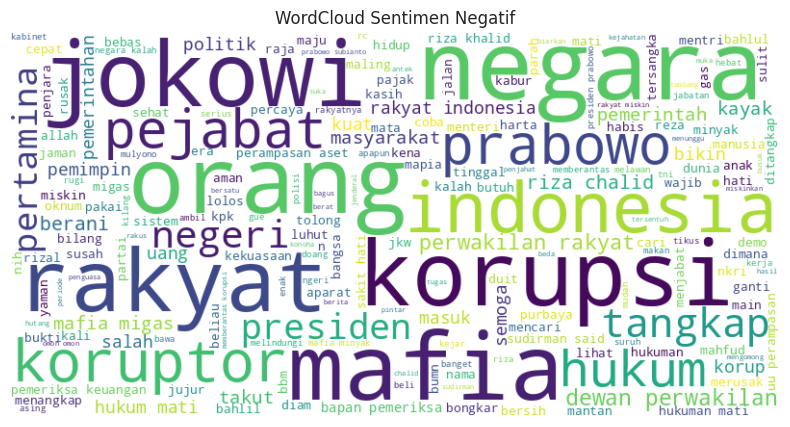

In [ ]:
# Membuat WordCloud untuk sentimen Negatif
create_wordcloud(sentimen_Negative, 'WordCloud Sentimen Negatif')

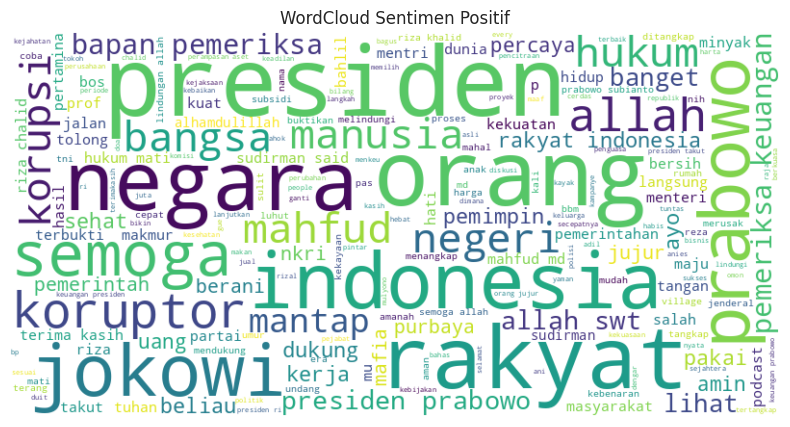

In [ ]:
# Membuat WordCloud untuk sentimen Positif
create_wordcloud(sentimen_Positive, 'WordCloud Sentimen Positif')

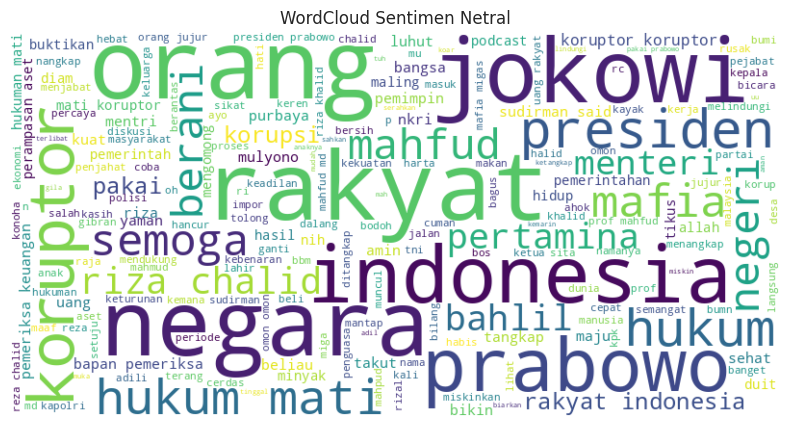

In [ ]:
# Membuat WordCloud untuk sentimen Netral
create_wordcloud(sentimen_Neutral, 'WordCloud Sentimen Netral')

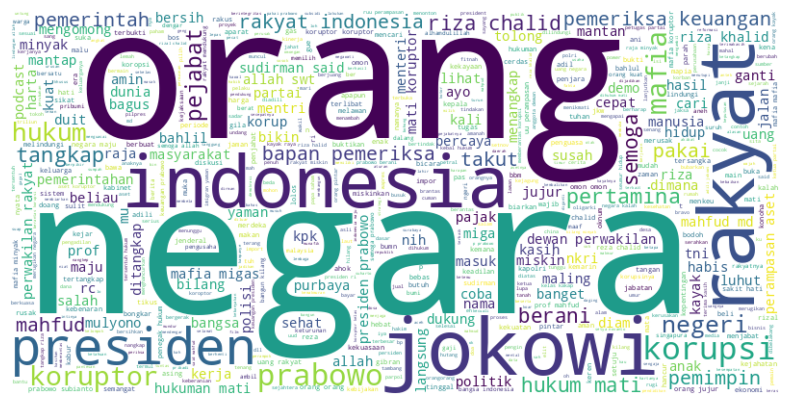

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


# Mengisi nilai NaN dengan string kosong ('')
data['stopword removal'] = data['stopword removal'].fillna('')

# Menggabungkan teks dari kolom
text = ' '.join(data['stopword removal'].astype(str).tolist())

stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'lu', 'deh'])

wc = WordCloud(stopwords=stopwords, background_color="white", max_words=1000, width=800, height=400)

wc.generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# ***FREKUENSI KATA***



In [ ]:
import pandas as pd

data = pd.read_csv("Hasil_Labelling_Data_3class.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


stopword removal  Score Sentiment
0  orang koruptor nkri biarkan melenggang negara ...      0    Netral
1  orang tsmgkap uang disita harta sita uang bawa...     -1   Negatif
2  halo halo jaksa riza callid malaysia riza oran...      0    Netral
3                    hukum mati miskinkan kelurganya      0    Netral
4  riza cholid wajib ditangkap kejar dimana inter...     -2   Negatif

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


In [ ]:
data = pd.DataFrame(data[['stopword removal','Sentiment']])
data.head(5)

stopword removal Sentiment
0  orang koruptor nkri biarkan melenggang negara ...    Netral
1  orang tsmgkap uang disita harta sita uang bawa...   Negatif
2  halo halo jaksa riza callid malaysia riza oran...    Netral
3                    hukum mati miskinkan kelurganya    Netral
4  riza cholid wajib ditangkap kejar dimana inter...   Negatif

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

# Pisahkan dataset berdasarkan sentimen
sentimen_Neutral = data[data['Sentiment'] == 'Netral']['stopword removal'].str.cat(sep=' ')
sentimen_Negative = data[data['Sentiment'] == 'Negatif']['stopword removal'].str.cat(sep=' ')
sentimen_Positive = data[data['Sentiment'] == 'Positif']['stopword removal'].str.cat(sep=' ')

# Stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update([
    'https', 'co', 'RT', '...', 'amp', 'lu', 'deh'])

# Fungsi hitung frekuensi kata + tampilkan jumlah
def plot_word_freq(text, title, color):
    words = [w for w in text.split() if w not in stopwords]
    word_freq = Counter(words).most_common(10)  # ambil 10 kata teratas
    df_freq = pd.DataFrame(word_freq, columns=['Kata', 'Frekuensi'])

    plt.figure(figsize=(8,5))
    bars = plt.barh(df_freq['Kata'], df_freq['Frekuensi'], color=color)
    plt.gca().invert_yaxis()  # biar kata frekuensi tertinggi di atas
    plt.title(f"Top 10 Kata - Sentimen {title}", fontsize=14)
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata")

    # Tambahkan label jumlah di ujung bar
    for bar in bars:
        plt.text(
            bar.get_width() + 0.2,  # posisi X sedikit ke kanan
            bar.get_y() + bar.get_height()/2,  # posisi Y di tengah bar
            str(int(bar.get_width())),  # nilai frekuensi
            va='center'
        )

    plt.show()

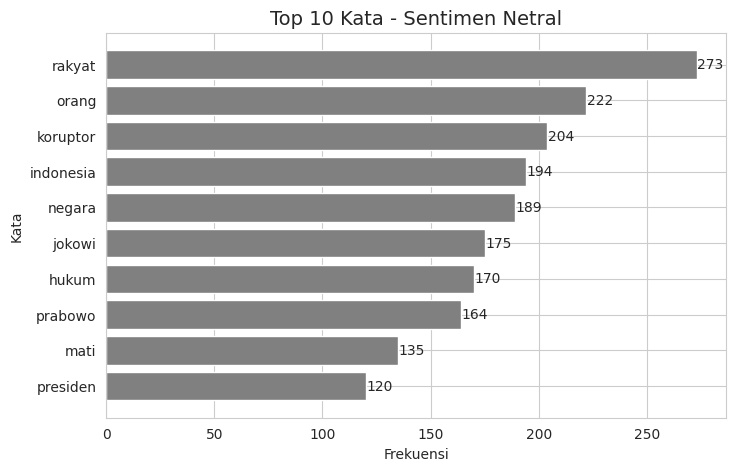

In [ ]:
plot_word_freq(sentimen_Neutral, "Netral", "gray")

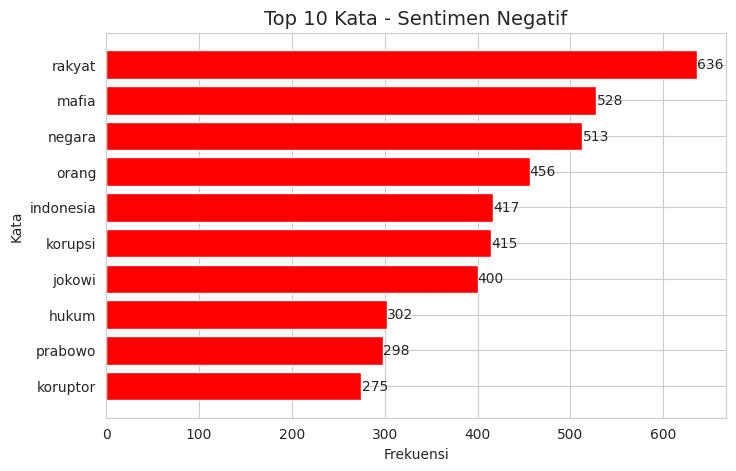

In [ ]:
plot_word_freq(sentimen_Negative, "Negatif", "red")

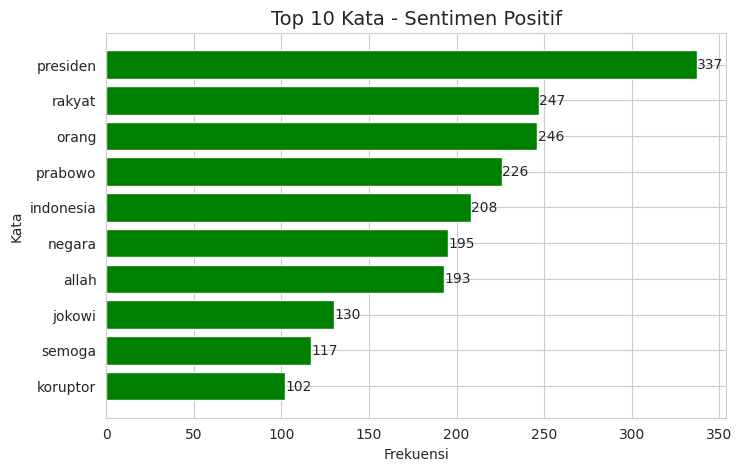

In [ ]:
plot_word_freq(sentimen_Positive, "Positif", "green")

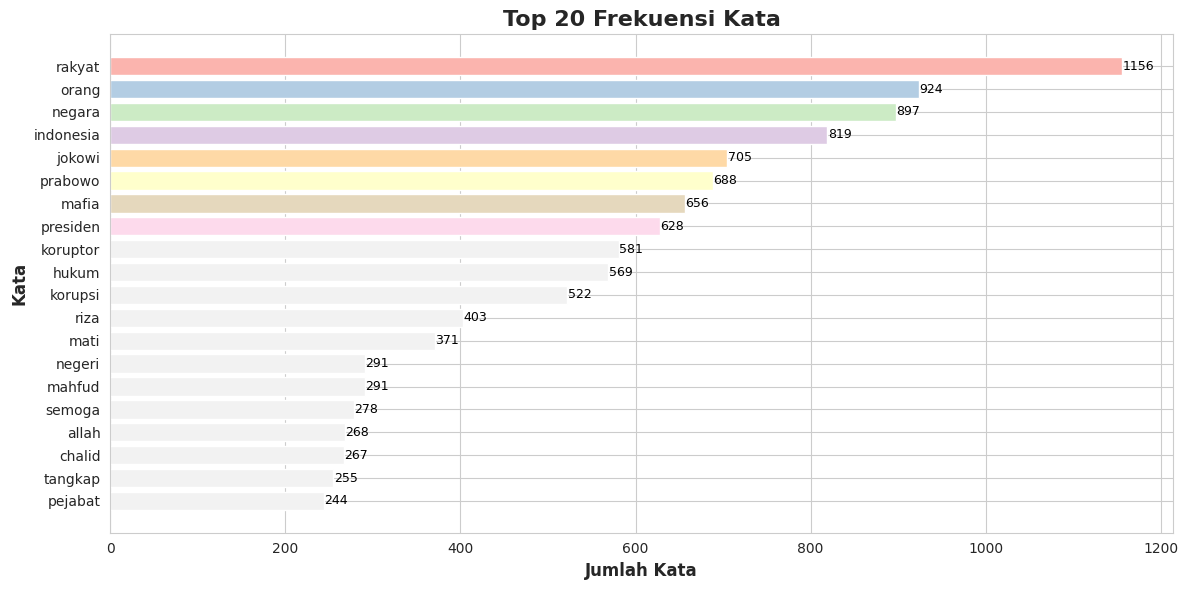

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Gabungkan semua teks
text = " ".join(data["stopword removal"])

tokens = text.split()
word_counts = Counter(tokens)

# Ambil 20 kata teratas
top_words = word_counts.most_common(20)
word, count = zip(*top_words)

# Palet warna soft (Pastel)
colors = plt.cm.Pastel1(range(len(word)))

plt.figure(figsize=(12, 6))
bars = plt.barh(word, count, color=colors)
plt.xlabel("Jumlah Kata", fontsize=12, fontweight='bold')
plt.ylabel("Kata", fontsize=12, fontweight='bold')
plt.title("Top 20 Frekuensi Kata", fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Biar frekuensi tertinggi di atas

# Tambahkan angka di ujung bar
for bar, num in zip(bars, count):
    plt.text(num + 0.5, bar.get_y() + bar.get_height()/2,
             str(num), va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


# ***N-Gram Frekuensi Kata***



In [ ]:
import pandas as pd

data = pd.read_csv("Hasil_Labelling_Data_3class.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


stopword removal  Score Sentiment
0  orang koruptor nkri biarkan melenggang negara ...      0    Netral
1  orang tsmgkap uang disita harta sita uang bawa...     -1   Negatif
2  halo halo jaksa riza callid malaysia riza oran...      0    Netral
3                    hukum mati miskinkan kelurganya      0    Netral
4  riza cholid wajib ditangkap kejar dimana inter...     -2   Negatif

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


In [ ]:
data = pd.DataFrame(data[['stopword removal','Sentiment']])
data.head(5)

stopword removal Sentiment
0  orang koruptor nkri biarkan melenggang negara ...    Netral
1  orang tsmgkap uang disita harta sita uang bawa...   Negatif
2  halo halo jaksa riza callid malaysia riza oran...    Netral
3                    hukum mati miskinkan kelurganya    Netral
4  riza cholid wajib ditangkap kejar dimana inter...   Negatif

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# Stopwords tambahan (bisa disesuaikan)
custom_stopwords = set(ENGLISH_STOP_WORDS)
custom_stopwords.update([
    'https', 'co', 'RT', '...', 'amp', 'lu', 'deh'])

# Fungsi buat ambil n-gram
def get_top_ngrams(corpus, n=3, top_k=10, stopwords=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Fungsi buat plot frekuensi n-gram
def plot_ngrams(corpus, sentiment_label, color_map=plt.cm.Set2, stopwords=None):
    top_ngrams = get_top_ngrams(corpus, n=3, top_k=10, stopwords=stopwords)
    if not top_ngrams:
        print(f"Tidak ada trigram untuk sentimen {sentiment_label}")
        return

    ngrams, counts = zip(*top_ngrams)
    colors = color_map(range(len(ngrams)))

    plt.figure(figsize=(10,6))
    bars = plt.barh(ngrams, counts, color=colors)
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Trigram - Sentimen {sentiment_label}", fontsize=16, fontweight='bold')
    plt.xlabel("Jumlah Kemunculan", fontsize=12)
    plt.ylabel("Trigram", fontsize=12)

    # Tambahin label jumlah di ujung bar
    for bar, num in zip(bars, counts):
        plt.text(num + 0.01, bar.get_y() + bar.get_height()/2,
                 str(num), va='center', fontsize=11, color='black')

    plt.tight_layout()
    plt.show()


# Ambil data per sentimen
corpus_neg = data[data['Sentiment'] == 'Negatif']['stopword removal'].astype(str).tolist()
corpus_neu = data[data['Sentiment'] == 'Netral']['stopword removal'].astype(str).tolist()
corpus_pos = data[data['Sentiment'] == 'Positif']['stopword removal'].astype(str).tolist()

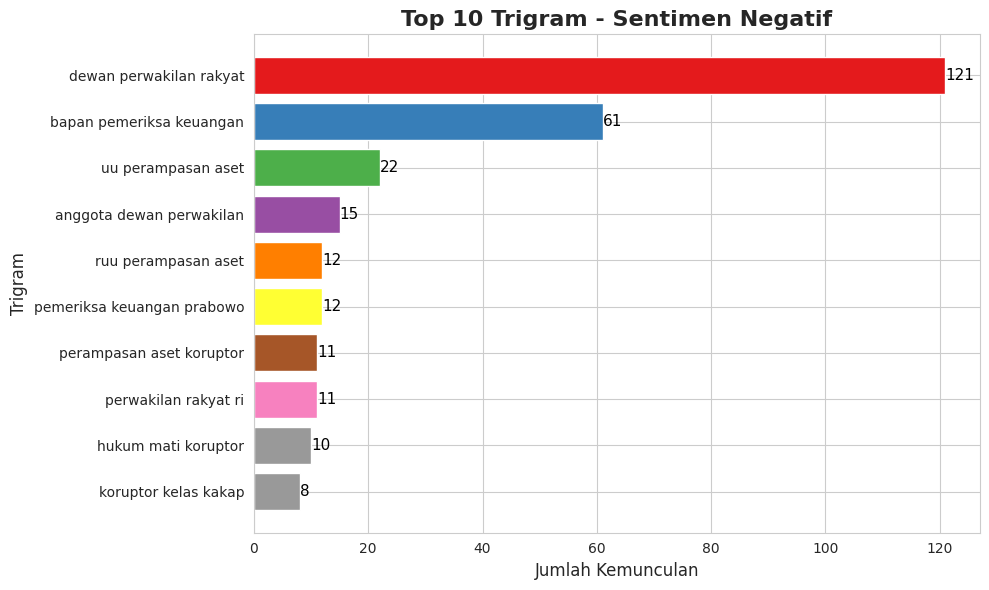

In [ ]:
plot_ngrams(corpus_neg, "Negatif", plt.cm.Set1)

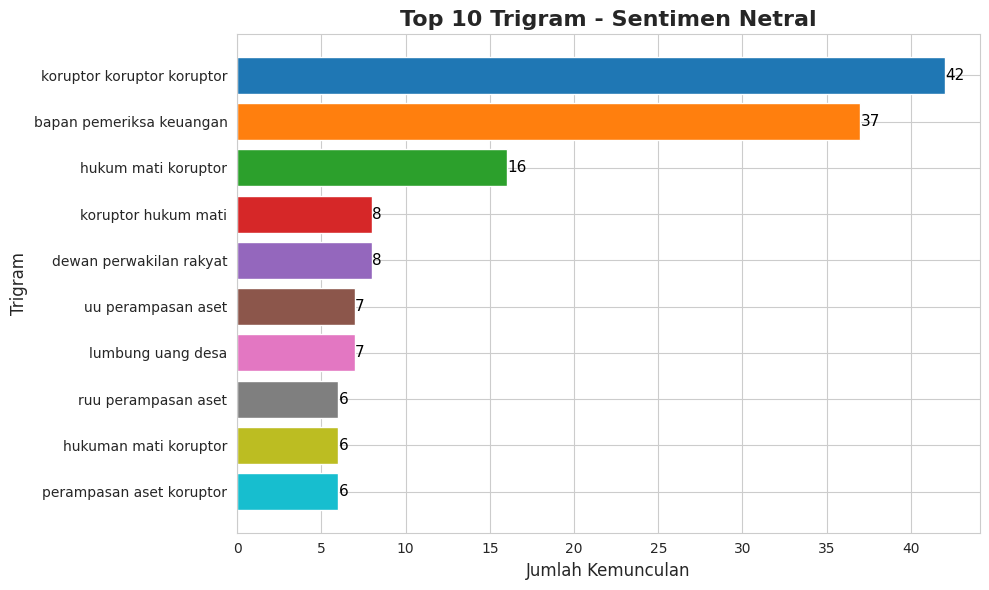

In [ ]:
plot_ngrams(corpus_neu, "Netral", plt.cm.tab10)

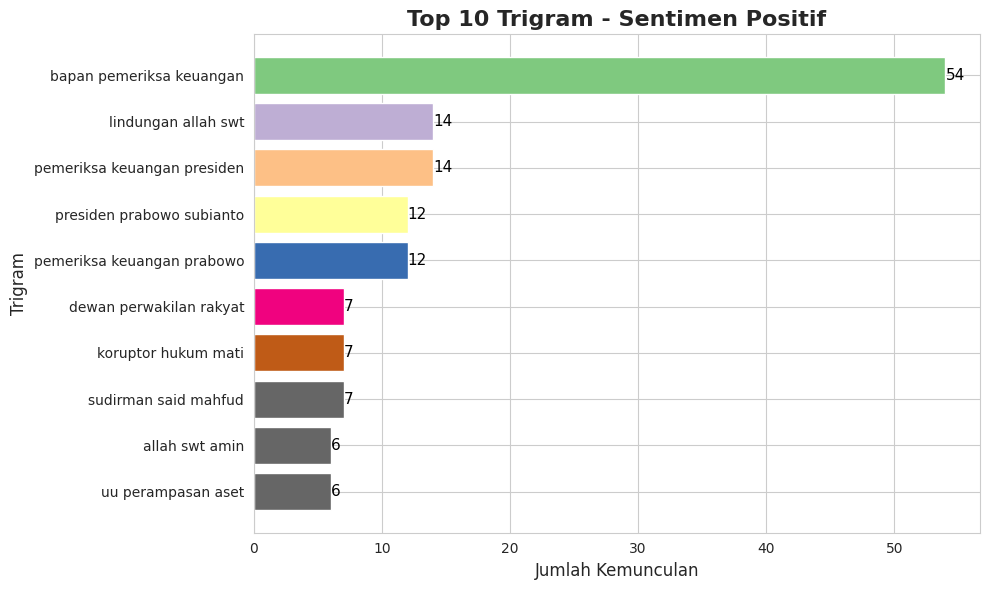

In [ ]:
plot_ngrams(corpus_pos, "Positif", plt.cm.Accent)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['rt'] not in stop_words.
  warnings.warn(


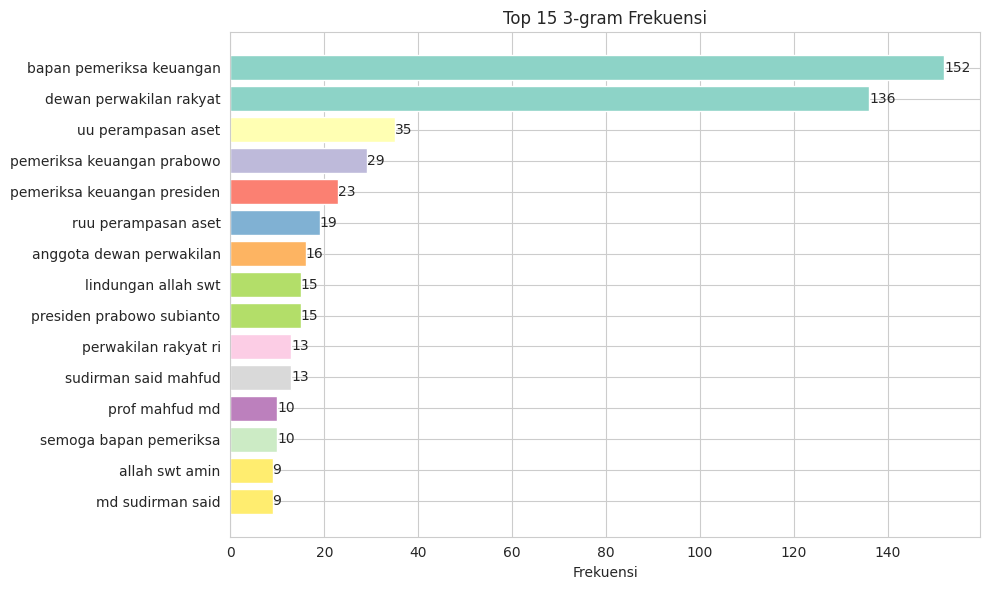

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Daftar stopwords tambahan
custom_stopwords = ['https', 'co', 'RT', '...', 'amp', 'lu', 'deh','koruptor','ai','berapa','can']

# Fungsi untuk membuat diagram batang frekuensi n-gram
def plot_ngram_frequencies(texts, ngram_range=(3,3), top_n=15, cmap=plt.cm.Set3):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=custom_stopwords)
    X = vectorizer.fit_transform(texts)

    # Hitung total frekuensi setiap n-gram
    ngram_counts = X.sum(axis=0).A1
    ngram_vocab = vectorizer.get_feature_names_out()
    freq_dist = dict(zip(ngram_vocab, ngram_counts))

    # Ambil n-gram dengan frekuensi tertinggi
    top_ngrams = Counter(freq_dist).most_common(top_n)
    labels, values = zip(*top_ngrams)

    # Buat warna berbeda untuk tiap bar
    colors = cmap(np.linspace(0, 1, len(labels)))

    # Visualisasi
    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels[::-1], values[::-1], color=colors[::-1])
    plt.title(f'Top {top_n} {ngram_range[0]}-gram Frekuensi')
    plt.xlabel('Frekuensi')

    # Tambahkan label angka di ujung bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', va='center')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan: Visualisasi 4-gram
plot_ngram_frequencies(data['stopword removal'], ngram_range=(3,3), top_n=15, cmap=plt.cm.Set3)

# ***SPLITTING DATA***

In [ ]:
import pandas as pd

file_path = "Hasil_Labelling_Data_3class.csv"
df = pd.read_csv(file_path)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   stopword removal  6308 non-null   object
 1   Score             6308 non-null   int64 
 2   Sentiment         6308 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.0+ KB


stopword removal  Score Sentiment
0  orang koruptor nkri biarkan melenggang negara ...      0    Netral
1  orang tsmgkap uang disita harta sita uang bawa...     -1   Negatif
2  halo halo jaksa riza callid malaysia riza oran...      0    Netral
3                    hukum mati miskinkan kelurganya      0    Netral
4  riza cholid wajib ditangkap kejar dimana inter...     -2   Negatif

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

df_clean = df.dropna(subset=['stopword removal'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_clean['Sentiment'])

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_clean['stopword removal'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'Negatif': np.int64(0), 'Netral': np.int64(1), 'Positif': np.int64(2)}

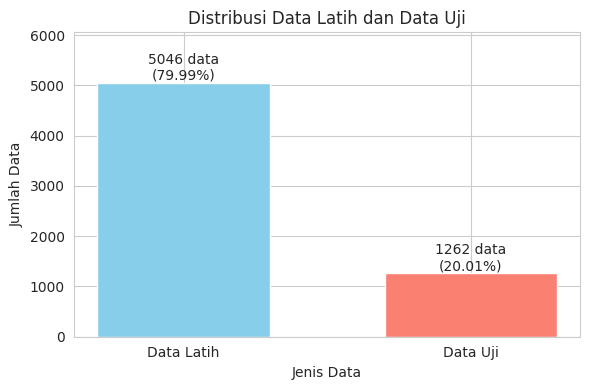

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = X_train.shape[0]
test_size = X_test.shape[0]
total_size = train_size + test_size

labels = ['Data Latih', 'Data Uji']
values = [train_size, test_size]
colors = ['skyblue', 'salmon']
x_pos = np.arange(len(labels))

plt.figure(figsize=(6, 4))
bars = plt.bar(x_pos, values, color=colors, width=0.6)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 3,
             f'{height} data\n({height / total_size * 100:.2f}%)',
             ha='center',
             va='bottom',
             fontsize=10)

plt.xticks(x_pos, labels)
plt.title('Distribusi Data Latih dan Data Uji', fontsize=12)
plt.xlabel('Jenis Data')
plt.ylabel('Jumlah Data')
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()


# ***SVM Karnel ('linear', 'rbf', 'poly', 'sigmoid')***

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}


=== Evaluasi Kernel: LINEAR ===
Akurasi: 0.7330

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.83      0.77      0.80       561
      Netral       0.62      0.77      0.69       449
     Positif       0.80      0.58      0.67       252

    accuracy                           0.73      1262
   macro avg       0.75      0.71      0.72      1262
weighted avg       0.75      0.73      0.73      1262



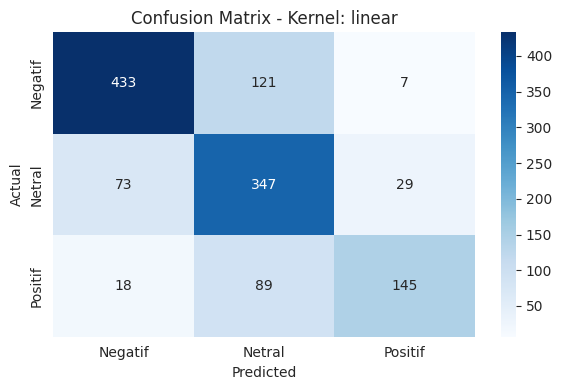


=== Evaluasi Kernel: RBF ===
Akurasi: 0.6989

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.79      0.77      0.78       561
      Netral       0.58      0.76      0.66       449
     Positif       0.84      0.42      0.56       252

    accuracy                           0.70      1262
   macro avg       0.74      0.65      0.67      1262
weighted avg       0.73      0.70      0.69      1262



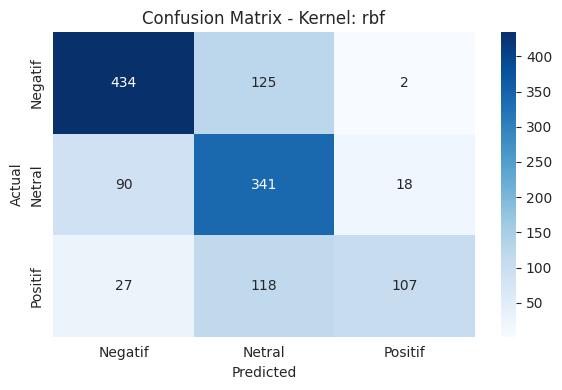


=== Evaluasi Kernel: POLY ===
Akurasi: 0.6006

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.58      0.91      0.70       561
      Netral       0.62      0.47      0.53       449
     Positif       0.91      0.16      0.27       252

    accuracy                           0.60      1262
   macro avg       0.70      0.51      0.50      1262
weighted avg       0.66      0.60      0.56      1262



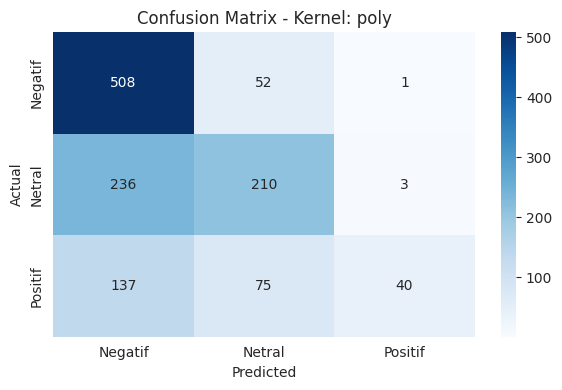


=== Evaluasi Kernel: SIGMOID ===
Akurasi: 0.7124

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.81      0.75      0.78       561
      Netral       0.60      0.76      0.67       449
     Positif       0.80      0.55      0.65       252

    accuracy                           0.71      1262
   macro avg       0.73      0.69      0.70      1262
weighted avg       0.73      0.71      0.71      1262



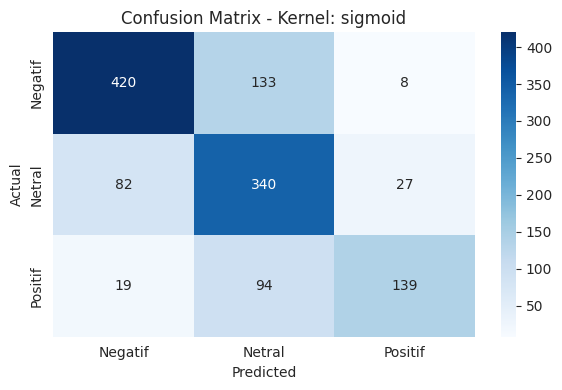

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_svm_kernel(kernel_name):
    print(f"\n=== Evaluasi Kernel: {kernel_name.upper()} ===")

    # Inisialisasi dan latih model
    model = SVC(kernel=kernel_name, random_state=42)
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Akurasi: {acc:.4f}")

    # Classification report
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    print("\nClassification Report:")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - Kernel: {kernel_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Evaluasi untuk setiap kernel
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    evaluate_svm_kernel(kernel)


/tmp/ipython-input-471162502.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


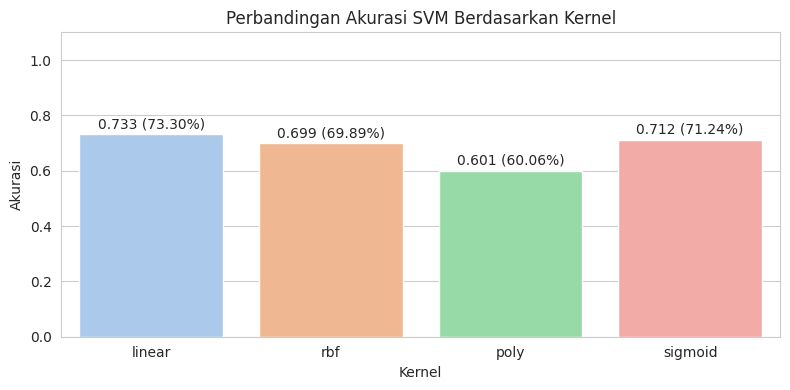

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

accuracy_results = {}

for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracy_results[kernel] = acc

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    x=list(accuracy_results.keys()),
    y=list(accuracy_results.values()),
    palette='pastel'
)
plt.title('Perbandingan Akurasi SVM Berdasarkan Kernel')
plt.ylabel('Akurasi')
plt.ylim(0, 1.1)
plt.xlabel('Kernel')

for bar in ax.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{height:.3f} ({height * 100:.2f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ***Simpan Model***

In [ ]:
from joblib import dump

# Simpan model SVM ke file
dump(model, 'svm_sentimen.h5')

# Jika ingin menyimpan juga TF-IDF vectorizer (agar bisa digunakan kembali saat prediksi)
dump(vectorizer, 'tfidf_vectorizer.pk')

print("Model dan vectorizer berhasil disimpan!")

Model dan vectorizer berhasil disimpan!


# ***Load Ulang untuk Prediksi***

In [ ]:
from joblib import load
import pandas as pd

# Load model dan vectorizer
model = load('svm_sentimen.joblib')
vectorizer = load('tfidf_vectorizer.joblib')

# Contoh input komentar baru
komentar_baru = [
    "Kasus ini sangat memalukan bagi bangsa",
    "Selamat dan sukses BPK RI!",
    "Semoga cepat terungkap kasus ini"
]

# Preprocessing sederhana (pastikan sesuai preprocessing awal)
komentar_tfidf = vectorizer.transform(komentar_baru)

# Prediksi sentimen (output numerik, misal 0=Negatif, 1=Netral, 2=Positif)
prediksi = model.predict(komentar_tfidf)

# Konversi label numerik ke teks
label_sentimen = {0: "Negatif", 1: "Netral", 2: "Positif"}

# Buat DataFrame hasil
hasil = pd.DataFrame({
    "Komentar": komentar_baru,
    "Sentimen": [label_sentimen[p] for p in prediksi]
})

# Tampilkan hasil
print(hasil)

                                 Komentar Sentimen
0  Kasus ini sangat memalukan bagi bangsa  Negatif
1              Selamat dan sukses BPK RI!  Positif
2        Semoga cepat terungkap kasus ini   Netral
